<a href="https://colab.research.google.com/github/alexakinbi/AliveCorKardia/blob/main/AliveCor_ATC_File_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib


Saving ecg-5e153723-89c0-42ea-9d78-8324bd86a479.atc to ecg-5e153723-89c0-42ea-9d78-8324bd86a479.atc
✅ Saved ECG data to: ecg-5e153723-89c0-42ea-9d78-8324bd86a479.csv


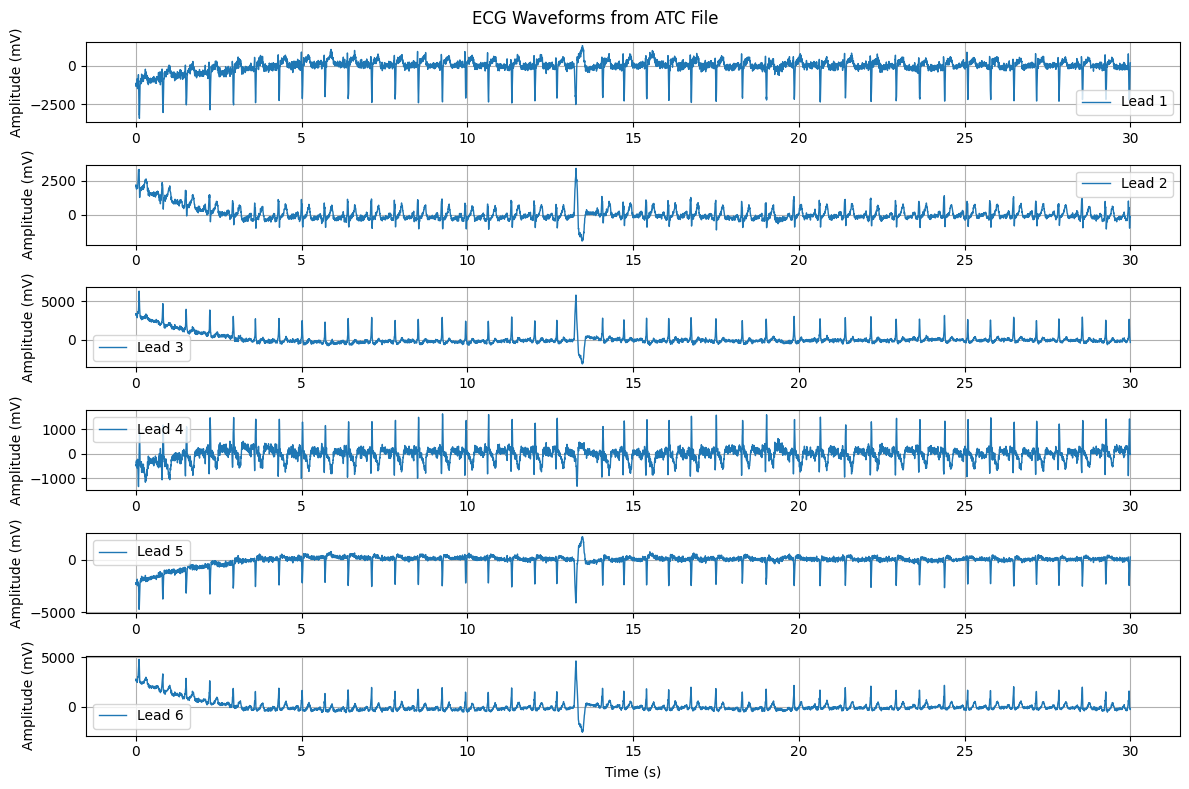

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import os

from typing import BinaryIO, Dict, Tuple

# Constants for ATC file parsing
FIRST_BLOCK_OFFSET = 0x0C
BLOCK_HEADER_LEN = 0x08
BLOCK_CHECKSUM_LEN = 0x04
FMT_SR_OFFSET = 0x01

FILE_HEADER = b'ALIVE'
FMT_BLOCK_IDENT = b'fmt '

# 6-lead ECG identifiers
LEAD_IDENTS = {
    1: b'ecg ',
    2: b'ecg2',
    3: b'ecg3',
    4: b'ecg4',
    5: b'ecg5',
    6: b'ecg6'
}

class ATCReader:
    """Reads .ATC ECG files and extracts data from different leads."""

    def __init__(self, fobj: BinaryIO):
        self.fobj = fobj
        self._blocks = {}

        if not self._check_header():
            raise ValueError("Invalid ATC file: Header not found")

        self._seek_blocks()

    def _seek(self, pos: int = 0):
        """Move to a specific position in the file"""
        self.fobj.seek(pos)

    def _tell(self) -> int:
        """Get current file position"""
        return self.fobj.tell()

    def _read(self, size: int) -> bytes:
        """Read a specific number of bytes"""
        return self.fobj.read(size)

    def _read_packed(self, fmt: str):
        """Read binary data in a given format"""
        import struct
        size = struct.calcsize(fmt)
        return struct.unpack(fmt, self._read(size))

    def _check_header(self) -> bool:
        """Verify if file starts with 'ALIVE'"""
        self._seek()
        header = self._read(len(FILE_HEADER))
        return header == FILE_HEADER

    def _seek_blocks(self) -> None:
        """Find and store the locations of data blocks"""
        self._seek(FIRST_BLOCK_OFFSET)

        while True:
            cur_off = self._tell()
            try:
                ident, blen = self._read_packed("<4sI")
            except:
                break
            self._blocks[ident] = (cur_off, blen)
            self._seek(cur_off + BLOCK_HEADER_LEN + blen + BLOCK_CHECKSUM_LEN)

    def read_sample_rate(self) -> int:
        """Extract the sample rate from the fmt block"""
        if FMT_BLOCK_IDENT not in self._blocks:
            raise ValueError("Sample rate block not found")
        self._seek(self._blocks[FMT_BLOCK_IDENT][0] + BLOCK_HEADER_LEN + FMT_SR_OFFSET)
        return self._read_packed("<H")[0]

    def read_lead(self, lead_id: int) -> np.ndarray:
        """Extract ECG data from a specific lead"""
        if lead_id not in LEAD_IDENTS:
            raise ValueError(f"Unknown lead: {lead_id}")
        if LEAD_IDENTS[lead_id] not in self._blocks:
            raise ValueError(f"Lead {lead_id} data not found")

        off, blen = self._blocks[LEAD_IDENTS[lead_id]]
        self._seek(off + BLOCK_HEADER_LEN)
        return np.frombuffer(self._read(blen), dtype=np.int16)

def convert_atc_to_csv(file_path: str, output_csv: str):
    """Read ATC file, extract all 6 leads, and save them to CSV"""
    with open(file_path, "rb") as f:
        reader = ATCReader(f)
        sample_rate = reader.read_sample_rate()
        ecg_data = {lead: reader.read_lead(lead) for lead in LEAD_IDENTS}

    # Ensure all leads have the same length
    min_length = min(len(data) for data in ecg_data.values())
    for lead in ecg_data:
        ecg_data[lead] = ecg_data[lead][:min_length]

    # Create time axis
    time = np.arange(min_length) / sample_rate

    # Create DataFrame
    df = pd.DataFrame({"Time (s)": time})
    for lead in range(1, 7):
        df[f"Lead {lead} (mV)"] = ecg_data[lead]

    # Save CSV
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved ECG data to: {output_csv}")

    return time, ecg_data

def plot_ecg(time: np.ndarray, ecg_data: Dict[int, np.ndarray]):
    """Plot all 6 ECG leads"""
    plt.figure(figsize=(12, 8))

    for lead in range(1, 7):
        plt.subplot(6, 1, lead)
        plt.plot(time, ecg_data[lead], label=f"Lead {lead}", linewidth=1)
        plt.ylabel("Amplitude (mV)")
        plt.legend()
        plt.grid()

    plt.xlabel("Time (s)")
    plt.suptitle("ECG Waveforms from ATC File")
    plt.tight_layout()
    plt.show()

# Upload .atc file
uploaded = files.upload()

# Get uploaded file name
atc_file = list(uploaded.keys())[0]

# Output CSV path
csv_file = atc_file.replace(".atc", ".csv")

# Process file
time, ecg_data = convert_atc_to_csv(atc_file, csv_file)
plot_ecg(time, ecg_data)

# Download CSV file to local system
files.download(csv_file)
